In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score, auc
_FOLDER = "./data/"

In [2]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm

In [3]:
import os
print(os.listdir("data"))

['Drug_Features2.csv', 'Cell_Lines_Details.csv', 'Drug_Features.csv', 'Cell_Line_Features_PANCAN_simple_MOBEM.xlsx', 'Cell_Line_Features_PANCAN_simple_MOBEM.tsv', 'normalised_dose_response_data.csv']


### normalised_dose_response_data.csv

In [4]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")
drug_curves.shape

(225384, 44)

In [5]:
drug_curves.head()

,Unnamed: 0,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,...,per_slope_change_7,slope_0,slope_1,slope_2,slope_3,slope_4,slope_5,slope_6,slope_7,slope_8
0,0,HDQ-P1,1290922,332,332_1290922,2,10.240,0,0.111111,0.222222,...,-2.14694,0.354085,-0.371905,0.069255,0.450075,-0.049503,-0.131784,0.246947,-1.239447,1.421566
1,1,HDQ-P1,1290922,257,257_1290922,2,10.240,0,0.111111,0.222222,...,-30.3283,-0.275239,0.163481,0.586129,0.180903,-0.221430,-0.349017,0.157822,0.087103,-2.554585
2,2,HDQ-P1,1290922,245,245_1290922,2,40.000,0,0.111111,0.222222,...,-0.618543,-0.394857,-0.615137,0.485215,-0.923687,0.466260,2.837371,-5.409070,-3.468825,-1.323207
3,3,HDQ-P1,1290922,155,155_1290922,2,0.512,0,0.111111,0.222222,...,1.14591,0.791510,-0.964611,1.238764,1.046952,-0.652559,-1.921061,-0.541266,-0.480877,-1.031916
4,4,HDQ-P1,1290922,192,192_1290922,2,16.000,0,0.111111,0.222222,...,1.53355,0.317413,0.044115,-0.604783,0.510820,-0.431190,0.575779,2.380415,-0.793585,-2.010587


In [6]:
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

In [8]:
def show_response_curves(df, plots_in_row, plots_in_column, x_columns, y_columns, start_index=0, indexes=[],
                         fitting_function =None, fitting_parameters =None):
    
    fig = plt.figure(figsize=(14, 11))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    n_plots= plots_in_row*plots_in_column
    
    if len(indexes) ==0:
        indexes =df.index[start_index : start_index+n_plots]
        
    try:
        for i, ind in list(enumerate(indexes)):
            x = df.loc[ind, x_columns]
            y = df.loc[ind, y_columns]
            auc_score = auc(x, y)
                
            ax = fig.add_subplot(plots_in_row, plots_in_column, i+1)
            ax.scatter(x,y)
            ax.set_title(str(ind)+"_"+str(df.loc[ind, "DRUG_ID"])+"_"+df.loc[ind, "CELL_LINE_NAME"]+" AUC: "+ str(round(auc_score, 4)))
            ax.set_xlabel("Scaled dosage")
            ax.set_ylabel("Normalised response")
            if fitting_function:
                ax2 = ax.twinx()
                x2 = np.linspace(0, 1, 10)
                fit_param =df.loc[ind, fitting_parameters]
                y2 = fitting_function(x2, *fit_param)
                ax2.plot(x2, y2, label= "R^2= %0.4f"% r2_score(y, y2))
                ax2.legend()
    except:
        print("ERROR: Number of indexes does not correspond to number of graphs to plot")

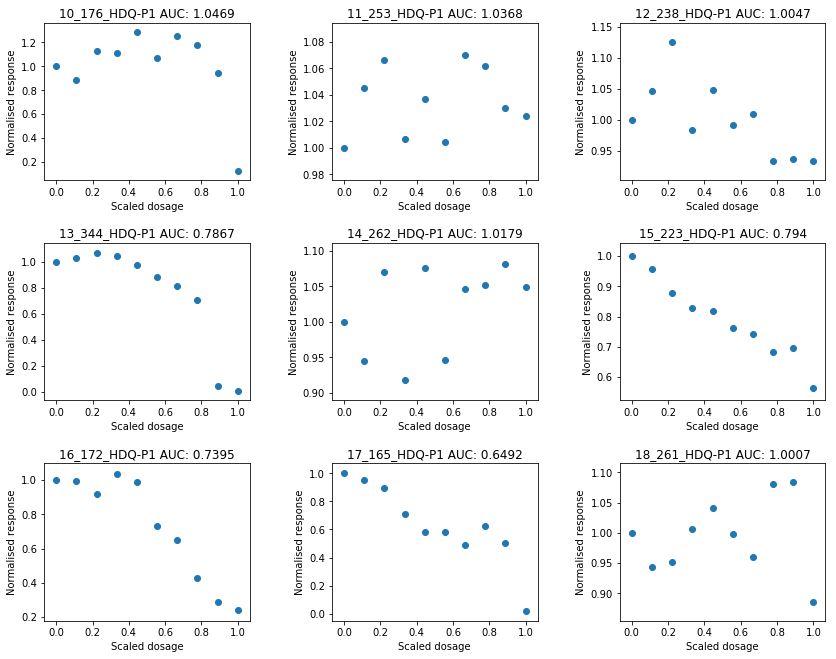

In [9]:
show_response_curves(drug_curves, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, 
                     y_columns= response_norm, start_index=0, indexes=drug_curves.index[10:19])

### Filtering

In [10]:
def filtering_before_fitting(df, first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2],
             tolerance=0.05, first_points_lower_limit = 0.8, last_points_upper_limit = 0.4):
    """
    tolerance =0.05 values to ensure the points form a plateu
    first_columns_to_compare = [1, 2]  - first columns two columns
    last_columns_to_compare = [-1, -2] - last two columns
    first_points_lower_limit = 0.8, 
    last_points_upper_limit = 0.4
    """
    df = df.copy()
    print("Original dataset:", df.shape)
    
    # 1. Ensure that all the response are less than 1

    index_row_more_than_1 = []
    for col in response_norm:
        if sum(df[col]>1)>0:
            index_row_more_than_1.extend(df[df[col]>1].index)
        
    index_row_less_than_1 = set(df.index) - set(index_row_more_than_1)
    df = df.loc[index_row_less_than_1, :].copy()
    
    print("\n 1st stage: Ensure that all the response are less than 1")
    print("1st stage filtration: Filtered dataset:", df.shape)
    
    # 2. Ensure that first and last points form a plateu
    # the minimal number of points are specified in the function arguments
    # by default, two points for both lpateus are considered

    df["dif_first"]=abs(df[response_norm[first_columns_to_compare[0]-1]]\
                                     - df[response_norm[first_columns_to_compare[1]-1]])
    df["dif_last"]=abs(df[response_norm[last_columns_to_compare[0]]] \
                                        - df[response_norm[last_columns_to_compare[1]]])

    df = df[(df["dif_first"]<= tolerance)
                           &(df["dif_last"]<= tolerance)]
    print("\n2d stage: Ensure that first and last points form a plateu")
    print("2d stage filtration: Filtered dataset:", df.shape)
    
    # 3. Specify location of the plateus - first_points_lower_limit and last_points_upper_limit
    df = df[(df[response_norm[1]]>first_points_lower_limit) 
                         & (df[response_norm[-1]]<last_points_upper_limit)]
    print("\n3d stage: first_points_lower_limit and last_points_upper_limit")
    print("3d stage filtration: Filtered dataset:", df.shape)
    
    return df

In [11]:
def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

def sigmoid_Vis(x, p, s):
    """ x - dosage [0, 1],
    p - position,
    s - shape parameter,
    """
    return 1.0 / (1.0 + np.exp((x-p)/s))

def sigmoid_4_param(x, x0, L, k, b):
    y = 1/ (L + np.exp(-k*(x-x0)))+b
    return y

def sigmoid_3_param(x, x0, k, b):
    y = 1/ (1 + np.exp(-k*(x-x0)))+b
    return y


def logistic4(x, A, B, C, D):
    """ https://people.duke.edu/~ccc14/pcfb/analysis.html
    4PL logistic equation."""
    return ((A-D)/(1.0+((x/C)**B))) + D

def ll4(x, b, c, d, e):
    ''' https://gist.github.com/yannabraham/5f210fed773785d8b638
    This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

def ll4_R(x, b, c, d, e):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
    """
    return c + (d-c)/(1+np.exp(b*np.log(x)- e))


def logLogistR(x, E_inf, EC50, HS):
    """Python analog for PharmacoGx/R/LogLogisticRegression.R
    https://github.com/bhklab/PharmacoGx/blob/master/R/LogLogisticRegression.R
    E = E_inf + (1 - E_inf)/(1 + (x/EC50)^HS)
    """
    return (E_inf+ (1-E_inf)/(1+(np.log10(x)/EC50)**HS))



def fit_curve_fit(fitting_function, x, y, parameters_guess=[], to_plot = False):
    parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)
    y_fit = fitting_function(x2, *parameters)
    r2 = r2_score(y, y_fit)

    if to_plot:
        print("Fitting parameters:", *parameters)
        plt.scatter(x, y)
        x2 = np.linspace(0, 1, 10)
        y2 = fitting_function(x2, *parameters)
        plt.plot(x2, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2, parameters
        
def residuals(p, x, y, function_to_fit):
    """Deviations of data from fitted curve"""
    err = y-function_to_fit(x, *p)
    return err

def fit_lsq(function_to_fit, x, y, parameters_guess =[], to_plot = False):
    param_lsq = leastsq(residuals, parameters_guess, args=(x, y, function_to_fit))
    y_fit = function_to_fit(x, *param_lsq[0])
    r2 = r2_score(y, y_fit)
    if to_plot:
        print("Fitting parameters:", *param_lsq[0])
        plt.scatter(x, y)
        x2 = np.linspace(0, 1, 10)
        y2 = fitting_function(x2, *parameters)
        plt.plot(x2, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2

def filtering_by_fitting_column(df, indexes, fitting_function, parameters_guess=[], default_param_number=0):
    """
    intial parameter guess [max(y), np.median(x), 1, min(y)]
    potentially they can be different for each data row, but as soon as we have scaled and filtered data
    we can use by default [1.0, 0.4, 1.0, .0] 
    """
    r2_scores = np.zeros(len(indexes))
    X = df.loc[indexes, conc_columns].values.astype(np.float32)
    Y = df.loc[indexes, response_norm].values.astype(np.float32)
    fitting_parameters = [None]*len(indexes)
    
    if default_param_number==4:
        parameters_guess = [1.0, 0.4, 1.0, .0] 
    elif default_param_number ==3:
        parameters_guess = [1.0, 0.4, .0] 
    else:
        pass
    
    for i in tqdm(range(len(indexes))):
        x = X[i, :]
        y = Y[i, :]
    
        try:
            r2_scores[i], fitting_parameters[i] = fit_curve_fit(fitting_function, x, y, parameters_guess = parameters_guess)
            
        except:
            r2_scores[i] = 0
    return r2_scores, fitting_parameters

In [24]:
%%time
df = filtering_before_fitting(drug_curves)

Original dataset: (225384, 44)

 1st stage: Ensure that all the response are less than 1
1st stage filtration: Filtered dataset: (63325, 44)

2d stage: Ensure that first and last points form a plateu
2d stage filtration: Filtered dataset: (6321, 46)

3d stage: first_points_lower_limit and last_points_upper_limit
3d stage filtration: Filtered dataset: (2776, 46)
CPU times: user 831 ms, sys: 166 ms, total: 996 ms
Wall time: 1.01 s


In [25]:
df.shape

(2776, 46)

In [26]:
%%time
r2, fit_param = filtering_by_fitting_column(df, df.index, fitting_function = sigmoid_4_param, default_param_number=4)
df["fitting_r2_s4"] = r2
df["fitting_param_s4"] = fit_param
# df= df[df["fitting_r2_s4"]!=0]
print(df.shape)

100%|██████████| 2776/2776 [00:07<00:00, 393.25it/s]

(2776, 48)
CPU times: user 6.91 s, sys: 241 ms, total: 7.15 s
Wall time: 7.07 s


In [27]:
df[["fitting_r2_s4", "fitting_param_s4"]]

,fitting_r2_s4,fitting_param_s4
131120,0.0,None
60,0.0,None
85,0.0,None
131171,0.0,None
112,0.0,None
...,...,...
130643,0.0,None
130792,0.0,None
130905,0.0,None
130920,0.0,None


In [20]:
%%time
r2, fit_param = filtering_by_fitting_column(df, df.index, fitting_function = sigmoid_3_param, default_param_number=3)
df["fitting_r2_s3"] = r2
df["fitting_param_s3"] = fit_param
df= df[df["fitting_r2_s3"]!=0]
print(df.shape)

0it [00:00, ?it/s]

(0, 56)
CPU times: user 8.89 ms, sys: 3.23 ms, total: 12.1 ms
Wall time: 10.3 ms


In [15]:
r2, fit_param = filtering_by_fitting_column(df, df.index, fitting_function = sigmoid_Vis, parameters_guess = [1, 5])
df["fitting_r2_svis"] = r2
df["fitting_param_svis"] = fit_param
df= df[df["fitting_r2_svis"]!=0]
print(df.shape)

0it [00:00, ?it/s]

(0, 52)


In [16]:
df[["fitting_r2_svis", "fitting_param_svis"]].head()

,fitting_r2_svis,fitting_param_svis


In [17]:
r2, fit_param = filtering_by_fitting_column(df, df.index, fitting_function = fsigmoid, parameters_guess = [1, 0.1])
df["fitting_r2_fs"] = r2
df["fitting_param_fs"] = fit_param
df= df[df["fitting_r2_fs"]!=0]
print(df.shape)

0it [00:00, ?it/s]


(0, 54)


In [18]:
r2, fit_param = filtering_by_fitting_column(df, df.index, fitting_function = ll4_R, default_param_number=4)
df["fitting_r2_ll4"] = r2
df["fitting_param_ll4"] = fit_param
df= df[df["fitting_r2_ll4"]!=0]
print(df.shape)

0it [00:00, ?it/s]

(0, 56)


In [19]:
max_int = len(df.index)
rand_int = np.random.randint(0, max_int, 9)
indexes_df=df.index[rand_int]

print("Fitting function: sigmoid_4_param")
show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                     start_index=59, indexes=indexes_df,
                    fitting_function = sigmoid_4_param, fitting_parameters ="fitting_param")

print("Fitting function: sigmoid_3_param")
show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                     start_index=59, indexes=indexes_df,
                    fitting_function = sigmoid_3_param, fitting_parameters ="fitting_param_s3")

print("Fitting function: fsigmoid")
show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                     start_index=59, indexes=indexes_df,
                    fitting_function = fsigmoid, fitting_parameters ="fitting_param_fs")


print("Fitting function: LL4")
show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                     start_index=59, indexes=indexes_df,
                    fitting_function = ll4_R, fitting_parameters ="fitting_param_ll4")

ValueError: low >= high

In [112]:
r2_columns = ['fitting_r2_s4', 'fitting_r2_svis', 'fitting_r2_fs', 'fitting_r2_s3', 'fitting_r2_ll4']
models = {0: "s4", 1: "svis", 2: "fs", 3:"s3", 4:"ll4"}

df["better_fitting"] = np.argmax(df[r2_columns].values, axis=1)
r2_col_res = r2_columns +["better_fitting"]
df["better_fitting"] = df["better_fitting"].map(models)
df[r2_col_res].head()

,fitting_r2_s4,fitting_r2_svis,fitting_r2_fs,fitting_r2_s3,fitting_r2_ll4,better_fitting
131120,0.996467,0.995452,0.995452,0.996302,0.993608,s4
85,0.997584,0.994659,0.994659,0.995039,0.997801,ll4
131171,0.997357,0.987070,0.987070,0.997270,0.997515,ll4
112,0.991678,0.969244,0.969244,0.979949,0.987341,s4
131208,0.997430,0.881946,0.881946,0.953390,0.997363,s4


In [115]:
df[r2_col_res].describe()

,fitting_r2_s4,fitting_r2_svis,fitting_r2_fs,fitting_r2_s3,fitting_r2_ll4
count,2.162000e+03,2162.000000,2162.000000,2162.000000,2162.000000
mean,9.394125e-01,0.963200,0.963648,0.981854,0.988330
std,2.137947e-01,0.054174,0.053354,0.027236,0.022150
min,-5.217151e-08,0.450343,0.450343,0.653780,0.659983
25%,9.853141e-01,0.957400,0.957977,0.978652,0.987399
50%,9.942794e-01,0.984155,0.984215,0.990264,0.994034
75%,9.975892e-01,0.993465,0.993494,0.995859,0.997326
max,9.999814e-01,0.999899,0.999899,0.999926,0.999981


In [121]:
ll4_min = df['fitting_r2_ll4'].min()
df_bad = df[df['fitting_r2_ll4']<0.9]

Fitting function: sigmoid_Vis


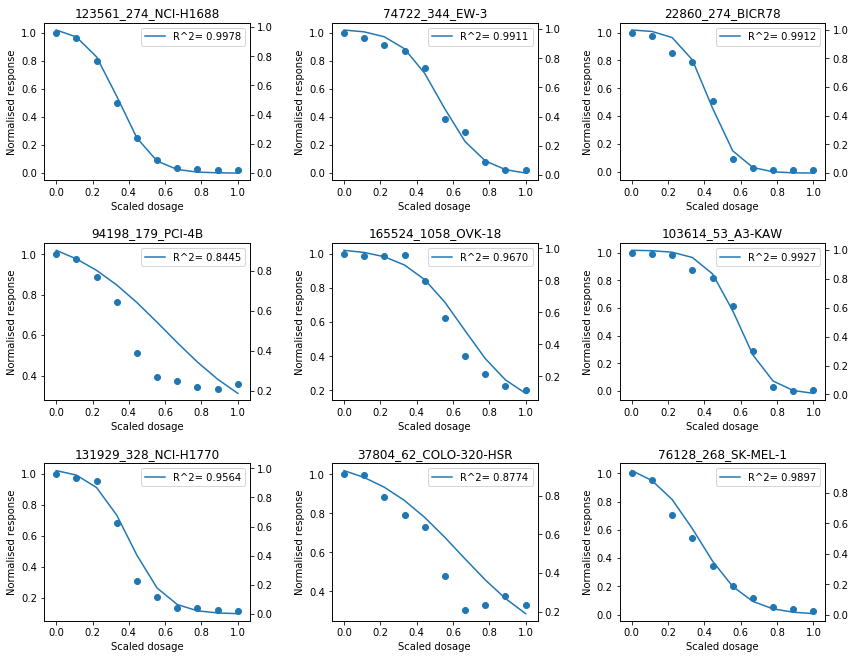

In [124]:
max_int = len(df.index)
rand_int = np.random.randint(0, max_int, 9)
indexes_df=df.index[rand_int]

print("Fitting function: sigmoid_Vis")
show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                     start_index=0, indexes=indexes_df,
                    fitting_function = sigmoid_Vis, fitting_parameters ="fitting_param_svis")

In [113]:
df["better_fitting"].value_counts()

s4     1392
ll4     729
s3       41
Name: better_fitting, dtype: int64

### Fitting curves

In [47]:
drug_id = 346
cell_line = "LU-65"
drug_curves[(drug_curves["DRUG_ID"]==drug_id)&(drug_curves["CELL_LINE_NAME"]== cell_line)].index

Int64Index([284], dtype='int64')

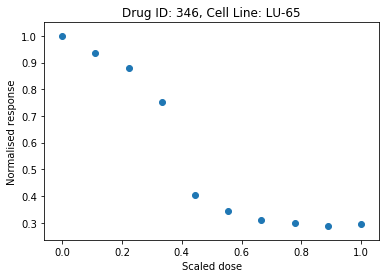

In [32]:
#good example
drug_id = 346
cell_line = "LU-65"
good = drug_curves[(drug_curves["DRUG_ID"]==drug_id)&(drug_curves["CELL_LINE_NAME"]== cell_line)]

plt.scatter(good.loc[good.index[0], conc_columns].values.astype(np.float32), 
            good.loc[good.index[0], response_norm].values.astype(np.float32))
plt.xlabel("Scaled dose")
plt.ylabel("Normalised response")
plt.title("Drug ID: %d, Cell Line: %s" % (drug_id, cell_line));

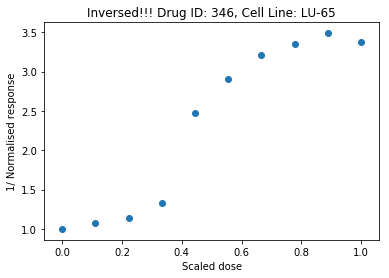

In [33]:
# good example
drug_id = 346
cell_line = "LU-65"
good = drug_curves[(drug_curves["DRUG_ID"]==drug_id)&(drug_curves["CELL_LINE_NAME"]== cell_line)]
x = good.loc[good.index[0], conc_columns].values.astype(np.float32),
y = 1/good.loc[good.index[0], response_norm].values.astype(np.float32)
plt.scatter(x, y)
plt.xlabel("Scaled dose")
plt.ylabel("1/ Normalised response")
plt.title("Inversed!!! Drug ID: %d, Cell Line: %s" % (drug_id, cell_line));

In [111]:
def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

def sigmoid_Vis(x, p, s):
    """ x - dosage [0, 1],
    p - position,
    s - shape parameter,
    """
    return 1.0 / (1.0 + np.exp(-(x-p)/s))

def sigmoid_4_param(x, x0, L, k, b):
    y = 1/ (L + np.exp(-k*(x-x0)))+b
    return y

def sigmoid_3_param(x, x0, k, b):
    y = 1/ (1 + np.exp(-k*(x-x0)))+b
    return y


def logistic4(x, A, B, C, D):
    """ https://people.duke.edu/~ccc14/pcfb/analysis.html
    4PL logistic equation."""
    return ((A-D)/(1.0+((x/C)**B))) + D

def ll4(x, b, c, d, e):
    ''' https://gist.github.com/yannabraham/5f210fed773785d8b638
    This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

def ll4_R(x, b, c, d, e):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
    """
    return c + (d-c)/(1+np.exp(b*np.log(x)- e))


def fit_curve_fit(fitting_function, x, y, parameters_guess=[], to_plot = False):
    parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)
    x2 = np.linspace(0, 1, 10)
    y2 = fitting_function(x2, *parameters)
    r2 = r2_score(y, y2)

    if to_plot:
        print("Fitting parameters:", *parameters)
        plt.scatter(x, y)
        plt.plot(x, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2, parameters
        
def residuals(p, x, y, function_to_fit):
    """Deviations of data from fitted curve"""
    err = y-function_to_fit(x, *p)
    return err

def fit_lsq(function_to_fit, x, y, parameters_guess =[], to_plot = False):
    param_lsq = leastsq(residuals, parameters_guess, args=(x, y, function_to_fit))
    y2 = function_to_fit(x, *param_lsq[0])
    r2 = r2_score(y, y2)
    if to_plot:
        print("Fitting parameters:", *param_lsq[0])
        plt.scatter(x, y)
        plt.plot(x, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2

In [35]:
# Inverted response
x = good.loc[good.index[0], conc_columns].values.astype(np.float32)
y = 1/good.loc[good.index[0], response_norm].values.astype(np.float32)

# fit_curve_fit(sigmoid_Vis, x, y, parameters_guess=[1, 5], to_plot = True)
# fit_lsq(x, y, sigmoid_Vis, parameters_guess=[1, 5], to_plot = True)

Fitting parameters: -4082539.0283247484 19931124.939608537


-3.2823075590826534e-08

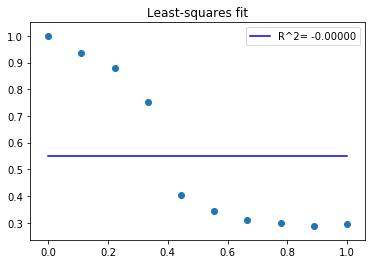

In [36]:
# Normal response
x = good.loc[good.index[0], conc_columns].values.astype(np.float32)
y = good.loc[good.index[0], response_norm].values.astype(np.float32)

#bounds are set as ([low_a,low_b],[high_a,high_b])
fit_curve_fit(sigmoid_Vis, x, y, parameters_guess=[1, 0.5], to_plot = True)

Fitting parameters: 7.523205551887484 0.2970497766424104 0.9466672350493502 0.36792284396941893


0.9917192755127807

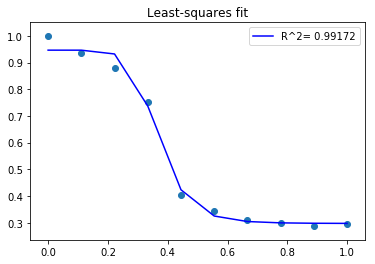

In [37]:
p0 = [max(y), np.median(x),1,min(y)]
fit_curve_fit(ll4, x, y, parameters_guess =p0, to_plot = True)

Fitting parameters: 0.3441752450702188 1.5128399848595575 -18.255477855267515 0.2997005952603317


0.9935016475653727

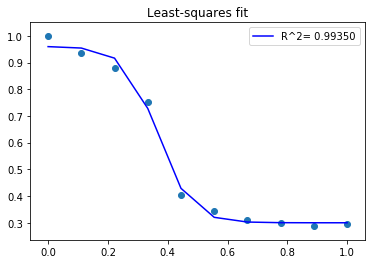

In [38]:
p0 = [max(y), np.median(x),1,min(y)]
fit_curve_fit(sigmoid_4_param, x, y, p0, to_plot = True)

Fitting parameters: 0.2782605164354585 -5.978300508020848 0.2331103208874468


0.9552315630039333

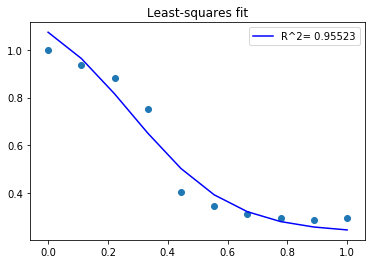

In [39]:
p0 = [max(y), np.median(x),min(y)]
fit_curve_fit(sigmoid_3_param, x, y, p0, to_plot = True)

Fitting parameters: 0.2970526941738411 -7.523259893217766 0.3679193144976095 0.9466692800576376


0.9917192801263175

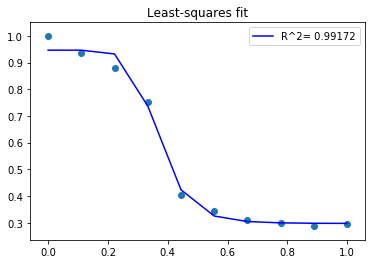

In [40]:
fit_lsq(logistic4, x, y, parameters_guess =[0, 1, 1, 1], to_plot = True)

Fitting parameters: 7.527285878644068 0.2970845477543197 0.9466496136230979 -7.526469821501663


0.9917192776183669

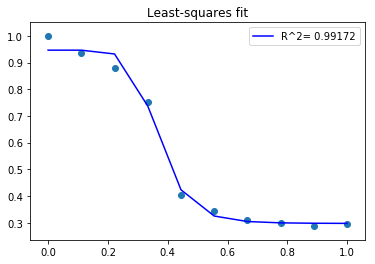

In [41]:
fit_lsq(ll4_R, x, y, parameters_guess =[max(y), np.median(x),1,min(y)], to_plot = True)

### Comparing models

In [126]:
x = good.loc[good.index[0], conc_columns].values.astype(np.float32)
y = good.loc[good.index[0], response_norm].values.astype(np.float32)


In [127]:
print("fsigmoid R2 % 0.4f"% fit_curve_fit(fsigmoid, x, y,parameters_guess=[1, 0.5])[0])
print("sigmoid_Vis R2 % 0.4f"% fit_curve_fit(sigmoid_Vis, x, y,parameters_guess=[1, 0.5])[0])
print("sigmoid_3_param R2 % 0.4f"% fit_curve_fit(sigmoid_3_param, x, y,parameters_guess= [max(y), np.median(x), min(y)])[0])
print("sigmoid_4_param R2 % 0.4f"% fit_curve_fit(sigmoid_4_param, x, y, parameters_guess= [max(y), np.median(x), 1, min(y)])[0])
# print("logistic4 R2 % 0.4f"% fit_lsq(logistic4,x, y,parameters_guess =[0, 1, 1, 1]))
print("logistic4 R2 % 0.4f"% fit_curve_fit(logistic4, x, y, parameters_guess =[0, 1, 1, 1])[0])
print("LL4 R2 % 0.4f"% fit_curve_fit(ll4_R, x, y,  parameters_guess= [max(y), np.median(x), 1, min(y)])[0])

fsigmoid R2  0.8476
sigmoid_Vis R2 -0.0000
sigmoid_3_param R2  0.9552
sigmoid_4_param R2  0.9935
logistic4 R2  0.9917
LL4 R2  0.9917


In [44]:
from tqdm import tqdm

In [149]:
def fit_curve_fit_column(df, indexes):
    
    r2_scores = np.zeros(len(indexes))
    X = df.loc[indexes, conc_columns].values.astype(np.float32)
    Y = df.loc[indexes, response_norm].values.astype(np.float32)
    fitting_parameters = [None]*len(indexes)
    
    for i in tqdm(range(len(indexes))):
        x = X[i, :]
        y = Y[i, :]
        try:
            r2_scores[i], fitting_parameters[i] = fit_curve_fit(sigmoid_4_param, x, y, parameters_guess= [max(y), np.median(x), 1, min(y)])
            
        except:
            #print(indexes[i])
            r2_scores[i] = 0
    return r2_scores, fitting_parameters

In [143]:
df2 = df_filt.copy()#loc[df_filt.index[16085:16095], :].copy()

In [144]:
df2.shape

(52540, 53)

In [ ]:
%%time
#around 5 min
r2, fit_param = fit_curve_fit_column(df2, df2.index)
df2["fitting_r2"] = r2
df2["fitting_param"] = fit_param

In [152]:
df2.to_csv("fitted_drugs.csv")

In [153]:
df2[["CELL_LINE_NAME", 'DRUG_ID', "fitting_r2", "fitting_param"]].head()

,CELL_LINE_NAME,DRUG_ID,fitting_r2,fitting_param
13,HDQ-P1,344,0.966718,"[0.8100850234454133, 0.9892494988253149, -26.2..."
15,HDQ-P1,223,0.000000,None
22,HDQ-P1,272,0.000000,None
24,HDQ-P1,328,0.971011,"[0.43349267675921827, 3.3889844600858483, -164..."
28,HDQ-P1,136,0.975429,"[0.6313296496301274, 0.9282910696470076, -5.82..."


In [178]:
df2[df2["fitting_r2"]==0].shape[0]

13133

In [179]:
fitted = df2[df2["fitting_r2"]!=0]

In [230]:
df2["dif_first"]=abs(df2[response_norm[0]] - df2[response_norm[1]])
df2["dif_last"]=abs(df2[response_norm[-2]] - df2[response_norm[-1]])

In [263]:
#r2>0.97 27711
fitted2 = df2[(df2["fitting_r2"]>0.98)&(df2[response_norm[-3]]<0.3)
              &(df2[response_norm[1]]>0.9) &(df2[response_norm[2]]>0.9)
              &(df2['dif_first']<0.02) & (df2['dif_last']<0.03)]
fitted2.shape

(1122, 57)

[ 961  504  510  218  529  497  372   43 1001]


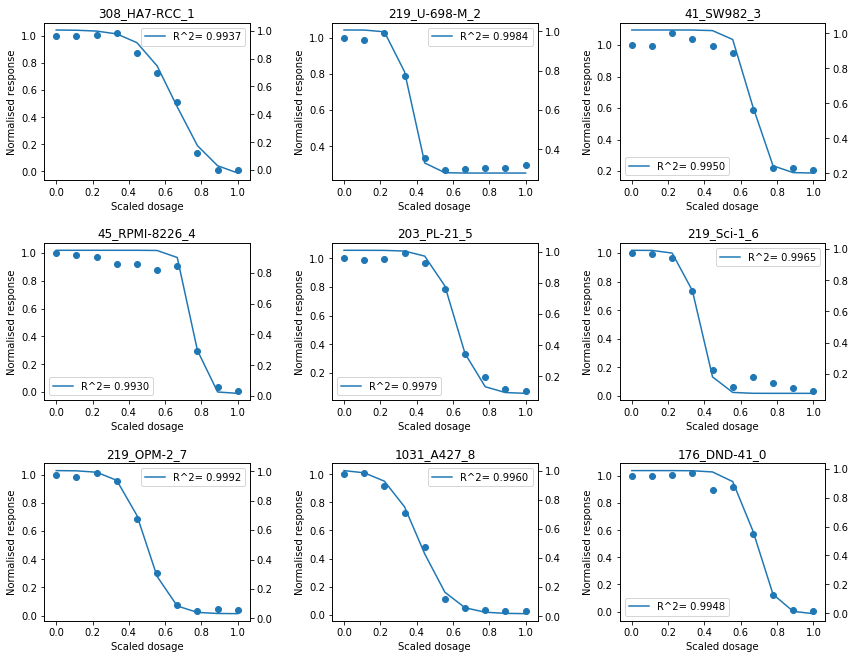

In [264]:
df = fitted2
max_int = len(df.index)
rand_int = np.random.randint(0, max_int, 9)
print(rand_int)

show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns= response_norm, 
                     start_index=0, indexes=df.index[rand_int],
                    fitting_function =sigmoid_4_param, fitting_parameters ="fitting_param")

### Useful

In [131]:
def logLogistR(x, E_inf, EC50, HS):
    """Python analog for PharmacoGx/R/LogLogisticRegression.R
    https://github.com/bhklab/PharmacoGx/blob/master/R/LogLogisticRegression.R
    E = E_inf + (1 - E_inf)/(1 + (x/EC50)^HS)
    """
    return (E_inf+ (1-E_inf)/(1+(np.log10(x)/EC50)**HS))

In [132]:
df.shape

(2162, 59)

In [130]:
n=1031
x = df.loc[n, conc_columns].values.astype(np.float32)
y = df.loc[n, response_norm].values.astype(np.float32)
plt.scatter(x, y);

KeyError: 1031

In [ ]:
xdata = np.array([400, 600, 800, 1000, 1200, 1400, 1600])
ydata = np.array([0, 0, 0.13, 0.35, 0.75, 0.89, 0.91])

def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

popt, pcov = curve_fit(fsigmoid, xdata, ydata, method='dogbox', bounds=([0., 600.],[0.01, 1200.]))
plt.scatter(xdata, ydata)
plt.plot(xdata, fsigmoid(xdata, *popt));

In [ ]:
r2_scores= []
guesses = np.linspace(-2,2,20)
for i in guesses:
    
    p0 = [i, 0.1]

    popt, pcov = curve_fit(fsigmoid, xdata_log, ydata, p0=p0, method='dogbox')
    y_fitted = fsigmoid(xdata_log, *popt) 
    r2 = r2_score(ydata, y_fitted)
    r2_scores.append(abs(r2))  
    
plt.scatter(guesses, r2_scores);
#but this parameter i = p should correspond to IC50! It means that it should be somewhere close to 0.4 
#as it comes from the visual analysis of the graph

In [ ]:
r2_scores= []
guesses = np.linspace(0,20,40)
for i in guesses:
    
    p0 = [0.4, i]

    popt, pcov = curve_fit(fsigmoid, xdata, ydata, p0=p0, method='dogbox')
    y_fitted = fsigmoid(xdata, *popt) 
    r2 = r2_score(ydata, y_fitted)
    r2_scores.append(abs(r2))  
    
plt.scatter(guesses, r2_scores);

In [ ]:
plt.plot(guesses, r2_scores);


In [ ]:
https://biopython.org/DIST/docs/api/Bio.phenotype.pm_fitting-pysrc.html

In [ ]:
Filtering logics:
    1. first values of y>1 => filter out
    2. last values of y >0.9 => filter out

In [ ]:
https://jbhender.github.io/Stats506/F18/GP/Group16.html

In [ ]:
https://www.futuremedicine.com/doi/pdf/10.2217/pgs.16.15

In [ ]:
drug_332_log[response_norm]=np.log(drug_332_log[response_norm])

In [ ]:
drug_332_short = drug_332['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID',
       'DRUGID_COSMICID', 'FOLD_DILUTION', 'MAX_CONC', 'fd_num_0', 'fd_num_1',
       'fd_num_2', 'fd_num_3', 'fd_num_4', 'fd_num_5', 'fd_num_6', 'fd_num_7',
       'fd_num_8', 'fd_num_9', 'norm_cells_0', 'norm_cells_1', 'norm_cells_2',
       'norm_cells_3', 'norm_cells_4', 'norm_cells_5', 'norm_cells_6',
       'norm_cells_7', 'norm_cells_8', 'norm_cells_9'].columns

In [ ]:
conc = np.array(drug_curves["MAX_CONC"].unique())
conc.min(), conc.max()

In [ ]:
drug_id=238
conc = np.array(drug_curves[drug_curves["DRUG_ID"]==drug_id]["MAX_CONC"].unique())

In [ ]:
several_conc =[]
for drug_id in drug_curves["DRUG_ID"].unique():
    conc = np.array(drug_curves[drug_curves["DRUG_ID"]==drug_id]["MAX_CONC"].unique())
    if len(conc)>1:
        several_conc.append(drug_id)
        print("Drug id: %d, Available concentrations: %d, min concetraion: %0.2f, max concetration: %0.2f" % (drug_id, len(conc), conc.min(), conc.max()))

In [ ]:
len(several_conc)

In [ ]:
drug_curves[drug_curves[conc_columns[-1]].isnull()][conc_columns]

In [ ]:
filter data drug vs different cells,
script to see which data are good, AUC, noise/data